# Setup

In [ ]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Dataset

In [ ]:
import pandas as pd
cols = ['preprocess', 'label',
        'NEG', 'POS', 'NEU',
        'num_word', 'num_char',
        'num_hashtag', 'num_url',
        'num_like_post', 'num_comment_post', 'num_share_post',
        'hour', 'weekday', 'day', 'month', 'year']
df = pd.read_csv('/content/drive/Shareddrives/[NCKH] /CODE/DATA/data_after_preprocessing_text_sa_timestamp_numeric.csv', usecols=cols)

In [ ]:
df = df.reindex(columns=cols)

In [ ]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   preprocess        4106 non-null   object 
 1   label             4106 non-null   int64  
 2   NEG               4106 non-null   float64
 3   POS               4106 non-null   float64
 4   NEU               4106 non-null   float64
 5   num_word          4106 non-null   int64  
 6   num_char          4106 non-null   int64  
 7   num_hashtag       4106 non-null   int64  
 8   num_url           4106 non-null   int64  
 9   num_like_post     4106 non-null   float64
 10  num_comment_post  4106 non-null   float64
 11  num_share_post    4106 non-null   float64
 12  hour              4106 non-null   int64  
 13  weekday           4106 non-null   int64  
 14  day               4106 non-null   int64  
 15  month             4106 non-null   int64  
 16  year              4106 non-null   int64  


,preprocess,label,NEG,POS,NEU,num_word,num_char,num_hashtag,num_url,num_like_post,num_comment_post,num_share_post,hour,weekday,day,month,year
0,cần các bậc phụ_huynh xã ngũ thái lên_tiếng kh...,1,0.985327,0.004864,0.009808,34,182,0,0,45.0,15.0,8.0,6,1,17,3,2020
1,kêu_gọi ăn_chay cầu_nguyện xin chúa cứu khỏi d...,1,0.659123,0.213645,0.127232,10,62,0,0,979.0,39.0,138.0,19,0,10,2,2020
2,giàn khoan dầu_khí gặp sự_cố chết người giàn k...,1,0.929886,0.016793,0.053320,41,212,0,0,85.0,13.0,61.0,12,3,16,4,2020
3,thuận_lợi có ca dương_tính cv19 rồi đó mọi ngư...,1,0.004563,0.982044,0.013393,28,151,0,0,114.0,12.0,5.0,10,0,3,8,2020
4,sa_pa cho 9 người khách nước_ngoài đi cùng chu...,1,0.038136,0.090191,0.871673,13,65,0,0,166.0,4.0,21.0,2,5,7,3,2020


In [ ]:
pd.DataFrame(df['label'].value_counts())

,label
0,3348
1,758


# Data Normalization

In [ ]:
numerical_cols = ['NEG', 'POS', 'NEU',
                  'num_word', 'num_char', 'num_hashtag', 'num_url',
                  'num_like_post', 'num_comment_post', 'num_share_post',
                  'hour', 'weekday', 'day', 'month', 'year']

for col in numerical_cols:
    scale = StandardScaler().fit(df[[col]])
    df[col] = scale.transform(df[[col]])

In [ ]:
df.head()

,preprocess,label,NEG,POS,NEU,num_word,num_char,num_hashtag,num_url,num_like_post,num_comment_post,num_share_post,hour,weekday,day,month,year
0,cần các bậc phụ_huynh xã ngũ thái lên_tiếng kh...,1,1.331592,-0.750723,-0.876529,-0.452903,-0.471984,-0.255596,-0.370426,-0.260416,-0.164019,-0.272612,-0.498758,-0.921436,0.114819,-1.040428,0.101316
1,kêu_gọi ăn_chay cầu_nguyện xin chúa cứu khỏi d...,1,0.558540,-0.181946,-0.517057,-0.889199,-0.873580,-0.255596,-0.370426,-0.128228,-0.127808,-0.196787,1.367536,-1.435417,-0.728774,-1.789376,0.101316
2,giàn khoan dầu_khí gặp sự_cố chết người giàn k...,1,1.200206,-0.718224,-0.743326,-0.325650,-0.371585,-0.255596,-0.370426,-0.254755,-0.167036,-0.241699,0.362609,0.106527,-0.005694,-0.291480,0.101316
3,thuận_lợi có ca dương_tính cv19 rồi đó mọi ngư...,1,-0.992660,1.911386,-0.865556,-0.561977,-0.575729,-0.255596,-0.370426,-0.250650,-0.168545,-0.274362,0.075487,-1.435417,-1.572368,2.704311,0.101316
4,sa_pa cho 9 người khách nước_ngoài đi cùng chu...,1,-0.913098,-0.518269,1.761914,-0.834662,-0.863540,-0.255596,-0.370426,-0.243291,-0.180615,-0.265029,-1.073002,1.134489,-1.090314,-1.040428,0.101316


#Function

In [ ]:
def get_metrics(y_test, y_pred_proba):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred_proba>=0.5), 4), '\n')
    print('ROC_AUC_SCORE: ', round(roc_auc_score(y_test, y_pred_proba), 4), '\n')
    print('F1_SCORE: ', round(f1_score(y_test, y_pred_proba>=0.5, average='macro'), 4), '\n')
    cm = confusion_matrix(y_test, y_pred_proba>=0.5)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Greens_r')  # Set the colormap to Blues

    ax.xaxis.set(ticks=(0, 1), ticklabels=('0', '1'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('0', '1'))
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=26, color='#FF0000')

    plt.ylabel('Actual')
    plt.xlabel('Predict')

    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Count', rotation=-90, va="bottom")

    plt.show()

In [ ]:
def get_numeric_data(x):
    return [record[1:].astype(float) for record in x]

def get_text_data(x):
    return [record[0] for record in x]

transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
            ('text_features', Pipeline([
                ('selector', transformer_text),
                ('tfidf', TfidfVectorizer(max_features=100000, ngram_range=(1,2))),
            ]))
    ])),
])

# Split data

In [ ]:
from sklearn.model_selection import train_test_split
labels=df['label']
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

# In số lượng mẫu trong từng phần
print("Số mẫu trong tập train:", len(x_train))
print("Số mẫu trong tập test:", len(x_test))

Số mẫu trong tập train: 3284
Số mẫu trong tập test: 822


# Data Pretrain

In [ ]:
x_train = x_train.drop(['label'], axis=1).to_numpy()
x_test = x_test.drop(['label'], axis=1).to_numpy()

In [ ]:
print(x_train)

[['tại_sao trung_quốc kiên_quyết không công_bố số_liệu thương_vong trong vụ xung_đột với ấn_độ dù thừa_nhận là có'
  -0.19170866771555348 -0.6783943073728762 ... 0.23533270200512216
  1.2064152206863497 0.10131560887374065]
 ['quá thương_tâm phó chủ_tịch ubnd quận bình_tân thành_phố hồ_chí_minh cho biết nạn_nhân trong vụ nghi phóng_hoả khiến 3 người chết ở phường bình trị đông b gồm cô và 2 cháu liên_quan đến vụ nghi phóng_hoả khiến 3 người chết tại một phòng trọ trên đường 21e phường bình trị đông b trao_đổi với phóng_viên ông nguyễn gia thái_bình phó chủ_tịch ubnd quận bình_tân cho biết đang chỉ_đạo các cơ_quan_chức_năng điều_tra làm rõ nguyên_nhân vụ cháy trước_mắt chính_quyền quận hỗ_trợ hơn 100 triệu đồng cho gia_đình để đưa nạn_nhân về quê an_táng thông_tin tôi nắm được 3 nạn_nhân tử_vong trong nhà_trọ là người_thân trong gia_đình gồm cô và 2 cháu tất_cả quê ở an_giang và lên sài_gòn thuê nhà_trọ để mưu_sinh bằng nghề bán trái_cây phó chủ_tịch ubnd quận bình_tân cho_hay'
  1.0511

In [ ]:
print(x_test)

[['công phượng gửi tin_vui tới thầy park khi duyên ghi_bàn trở_lại với 2 bàn thắng trong 2 trận đấu liên_tiếp tại 2020'
  -0.9818676200035371 1.5097949427704285 ... 0.8378994732903746
  1.2064152206863497 0.10131560887374065]
 ['xứ thanh kỳ ghê cục trưởng cục thi_hành án dân_sự tỉnh thanh_hoá bùi_mạnh khoa đã có văn_bản báo_cáo khẩn_cấp về việc ông đặng_phạm viên chi_cục trưởng chi_cục thi_hành án dân_sự tp thanh_hoá đã tử_vong bất_thường'
  1.3373177344963172 -0.7529108068614551 ... 0.47635941051922315
  -0.2914804237461119 0.10131560887374065]
 ['hôm_nay 10 3 âm_lịch là ngày giỗ tổ hùng vương theo ban tổ_chức năm nay giỗ tổ hùng vương chỉ tổ_chức 3 hoạt_động lễ chính gồm lễ giỗ đức quốc tổ lạc_lõng quân lễ dâng hương tổ mẫu âu cơ trong đó lễ dâng hương giỗ tổ hùng vương sẽ bắt_đầu lúc 9 giờ sáng nay 2 4 trước nguy_cơ lây_lan của dịch_bệnh covid ban tổ_chức cho biết năm nay chỉ tổ_chức phần lễ không tổ_chức phần hội với tinh_thần đơn_giản gọn_nhẹ nhưng đảm_bảo trang_nghiêm thành_kính 

In [ ]:
x_train = pipeline.fit_transform(x_train)
x_test = pipeline.transform(x_test)
y_train = y_train.values
y_test = y_test.values

print(x_train.shape)
print(x_test.shape)

(3284, 100015)
(822, 100015)


# Train and evaluate


[LightGBM] [Info] Number of positive: 598, number of negative: 2686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39620
[LightGBM] [Info] Number of data points in the train set: 3284, number of used features: 1512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182095 -> initscore=-1.502218
[LightGBM] [Info] Start training from score -1.502218
ACCURACY_SCORE:  0.9258 

ROC_AUC_SCORE:  0.9455 

F1_SCORE:  0.8733 



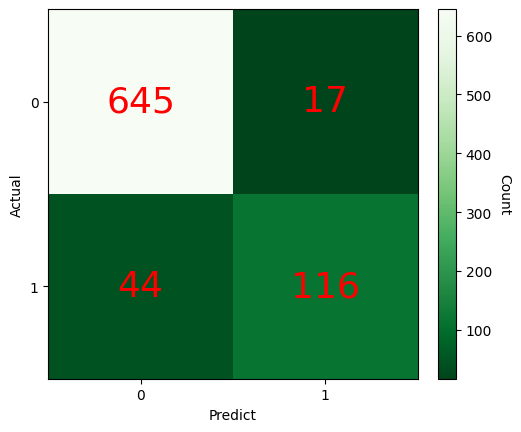

In [ ]:
import matplotlib.pyplot as plt
model = LGBMClassifier()
model.fit(x_train, y_train)
y_pred_proba = model.predict_proba(x_test) [:,1]
get_metrics(y_test, y_pred_proba)

# Table score

In [ ]:
list_model = [LogisticRegression(solver='liblinear'), SVC(kernel = 'linear', probability = True),
              LGBMClassifier(), XGBClassifier(), CatBoostClassifier(verbose = 200)]

list_model_name, list_acc_score, list_f1_score, list_roc_auc = [], [], [], []

In [ ]:
for model in list_model:
    print(f"{type(model).__name__} .....\n")
    model.fit(x_train, y_train)
    y_pred_proba = model.predict_proba(x_test) [:,1]
    list_model_name.append(type(model).__name__);
    list_acc_score.append(accuracy_score(y_test, y_pred_proba>=0.5))
    list_f1_score.append(f1_score(y_test, y_pred_proba>=0.5, average='macro'))
    list_roc_auc.append(roc_auc_score(y_test, y_pred_proba))

LogisticRegression .....

SVC .....

LGBMClassifier .....

[LightGBM] [Info] Number of positive: 598, number of negative: 2686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39620
[LightGBM] [Info] Number of data points in the train set: 3284, number of used features: 1512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182095 -> initscore=-1.502218
[LightGBM] [Info] Start training from score -1.502218
XGBClassifier .....

CatBoostClassifier .....

Learning rate set to 0.017117
0:	learn: 0.6836725	total: 719ms	remaining: 11m 58s
200:	learn: 0.2913306	total: 1m 35s	remaining: 6m 18s
400:	learn: 0.2452920	total: 3m 10s	remaining: 4m 44s
600:	learn: 0.2080358	total: 4m 45s	remaining: 3m 9s
800:	learn: 0.1714239	total: 6m 20s	remaining: 1m 34s
999:	learn: 0.1466286	total: 7m 55s	rema

In [ ]:
table_cols = {'Model name': list_model_name, 'Accuracy score': list_acc_score,
              'Macro-F1 score': list_f1_score, 'ROC-AUC score': list_roc_auc}
table = pd.DataFrame(table_cols)
table = table.sort_values(by=['ROC-AUC score'], ascending=False).reset_index(drop=True)
table

,Model name,Accuracy score,Macro-F1 score,ROC-AUC score
0,LGBMClassifier,0.925791,0.873329,0.945544
1,SVC,0.907543,0.845856,0.941791
2,XGBClassifier,0.912409,0.850085,0.936641
3,CatBoostClassifier,0.896594,0.806434,0.930702
4,LogisticRegression,0.860097,0.703923,0.924084


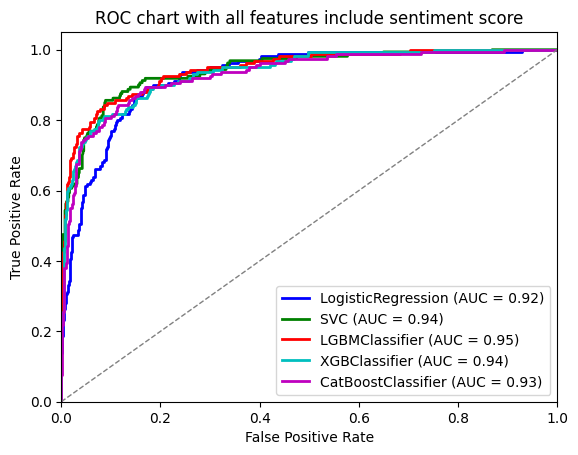

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Tạo một mảng chứa màu sắc cho các đường ROC
colors = ['b', 'g', 'r', 'c', 'm']

# Vẽ biểu đồ ROC-AUC cho từng mô hình trong danh sách
for i, model in enumerate(list_model):
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường ROC
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{list_model_name[i]} (AUC = {roc_auc:.2f})')

# Vẽ đường thẳng tham chiếu
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Cấu hình biểu đồ
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC chart with all features include sentiment score')
plt.legend(loc='lower right')

# Hiển thị biểu đồ ROC-AUC
plt.show()